In [1]:
!pip install --pre deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 15.8 MB/s eta 0:00:00


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [3]:
!pip install triton

In [4]:
import torch
import datetime
import numpy as np
import deepchem as dc
import torch_geometric
import triton

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [5]:
import matplotlib.pyplot as plt

In [6]:
torch._dynamo.config.cache_size_limit = 64

In [8]:
tasks, datasets, transformers = dc.molnet.load_freesolv(featurizer=dc.feat.DMPNNFeaturizer(), splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

In [9]:
len(train_dataset)
len(valid_dataset)
len(test_dataset)

65

In [10]:
model = dc.models.DMPNNModel()

In [11]:
model.compile()

In [12]:
model.fit(train_dataset, nb_epoch=10)

W0311 16:47:58.532000 564 torch/_dynamo/exc.py:284] [0/0] Backend compiler failed with a fake tensor exception at 
W0311 16:47:58.532000 564 torch/_dynamo/exc.py:284] [0/0]   File "/usr/local/lib/python3.11/dist-packages/deepchem/models/torch_models/dmpnn.py", line 449, in forward
W0311 16:47:58.532000 564 torch/_dynamo/exc.py:284] [0/0]     return final_output
W0311 16:47:58.532000 564 torch/_dynamo/exc.py:284] [0/0] Adding a graph break.
W0311 16:47:58.818000 564 torch/_dynamo/exc.py:284] [0/0_1] Backend compiler failed with a fake tensor exception at 
W0311 16:47:58.818000 564 torch/_dynamo/exc.py:284] [0/0_1]   File "/usr/local/lib/python3.11/dist-packages/deepchem/models/torch_models/dmpnn.py", line 449, in forward
W0311 16:47:58.818000 564 torch/_dynamo/exc.py:284] [0/0_1]     return final_output
W0311 16:47:58.818000 564 torch/_dynamo/exc.py:284] [0/0_1] Adding a graph break.
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


0.07403771877288819

In [13]:
metric = [dc.metrics.Metric(dc.metrics.pearson_r2_score),
          dc.metrics.Metric(dc.metrics.mean_squared_error)]

In [14]:
print(f"Training MSE: {model.evaluate(train_dataset, metric)}")


Training MSE: {'pearson_r2_score': 0.929681781219872, 'mean_squared_error': 0.09062924663204508}


In [15]:
print(f"Test MSE: {model.evaluate(test_dataset, metric)}")

Test MSE: {'pearson_r2_score': 0.861763129080576, 'mean_squared_error': 0.11210735015399237}


In [16]:
print(f"Valid MSE: {model.evaluate(valid_dataset, metric)}")


Valid MSE: {'pearson_r2_score': 0.8488340132911086, 'mean_squared_error': 0.15920862387548324}


In [17]:
def torch_function(fn):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end)/1000

In [19]:
track_dict = {}
prev_time_dict = {}

In [18]:
def get_time_track_callback(track_dict, track_name, track_interval):
    track_dict[track_name] = []
    prev_time_dict[track_name] = datetime.datetime.now()
    def callback(model, step):
        if step % track_interval == 0:
            elapsed_time = (datetime.datetime.now() - prev_time_dict[track_name])
            track_dict[track_name].append(elapsed_time.total_seconds())
            prev_time_dict[track_name] = datetime.datetime.now()
    return callback

In [23]:
model = dc.models.DMPNNModel()
model_compiled = dc.models.DMPNNModel()
model_compiled.compile(mode='reduce-overhead')

track_interval = 20
eager_dict_name = "eager_train"
compiled_dict_name = "compiled_train"

eager_train_callback = get_time_track_callback(track_dict, eager_dict_name, track_interval)
model.fit(train_dataset, nb_epoch=10, callbacks=[eager_train_callback])

compiled_train_callback = get_time_track_callback(track_dict, compiled_dict_name, track_interval)
model_compiled.fit(train_dataset, nb_epoch=10, callbacks=[compiled_train_callback])


0.14926269849141438

In [24]:
eager_train_times = track_dict[eager_dict_name]
compiled_train_times = track_dict[compiled_dict_name]

print(f"Eager Times (first 15): {[f'{t:.3f}' for t in eager_train_times[:15]]}")
print(f"Compiled Times (first 15): {[f'{t:.3f}' for t in compiled_train_times[:15]]}")
print(f"Total Eager Time: {sum(eager_train_times)}")
print(f"Total Compiled Time: {sum(compiled_train_times)}")
print(f"Eager Median: {np.median(eager_train_times)}")
print(f"Compiled Median: {np.median(compiled_train_times)}")
print(f"Median Speedup: {((np.median(eager_train_times) / np.median(compiled_train_times)) - 1) * 100:.2f}%")

Eager Times (first 15): ['0.291', '0.281', '0.260', '0.222', '0.227', '0.230', '0.237', '0.231', '0.221', '0.228', '0.227', '0.240', '0.216', '0.213', '0.221']
Compiled Times (first 15): ['2.503', '0.231', '0.220', '1.075', '0.236', '0.221', '2.466', '0.216', '0.224', '0.215', '0.213', '0.213', '0.207', '0.226', '0.219']
Total Eager Time: 59.75815299999997
Total Compiled Time: 63.287136
Eager Median: 0.219112
Compiled Median: 0.212304
Median Speedup: 3.21%


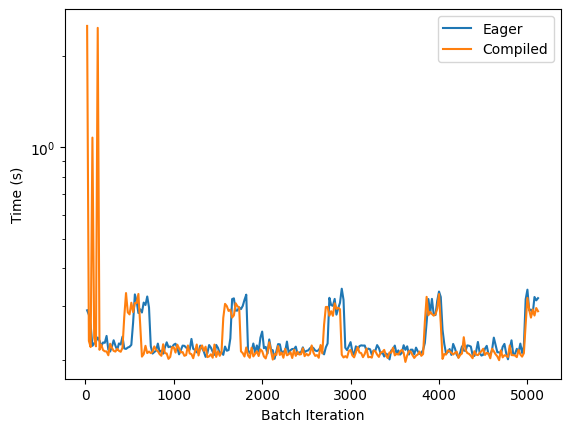

In [25]:
x_vals = np.arange(1, len(eager_train_times) + 1) * track_interval
plt.plot(x_vals, eager_train_times, label="Eager")
plt.plot(x_vals, compiled_train_times, label="Compiled")
plt.yscale('log', base= 10)
plt.ylabel('Time (s)')
plt.xlabel('Batch Iteration')
plt.legend()
plt.show()